#### Trajectories
- Interpretable
- predefined max instances (as in instance segmentation)
- each foreground instance has own trajectory (background has ego trajectory - odometry)
- Id masks [t, N, M]
- trajectory in format [t, M; x,y,z,l,w,h]
- heading, velocity, acceleration re-computed online
- losses applied rigid motion, flow, points in, trajectory, box NN search
- initialize with neural prior to get good init flow for frame 1
- continue propagation to other frames

#### Issues
- How to initialize? - neural prior and instance segmentation with smoothness
- Design choices of what loss should have priority

torch.Size([10, 6, 7])
torch.Size([10, 6, 8, 3])
You do not have IPython installed!


/home/ruslan/CTU/sceneflow/4D-RNSFP/notebooks/../vis/deprecated_vis.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(URL)
/home/ruslan/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


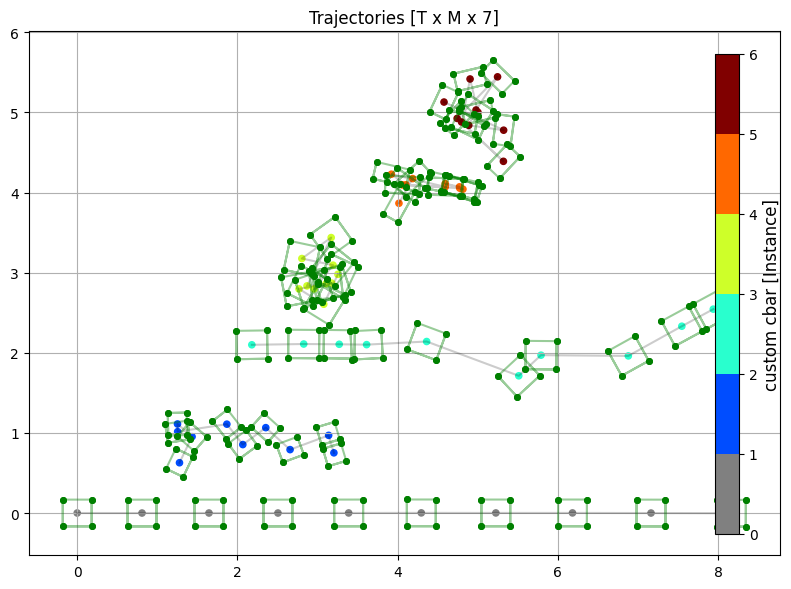

In [14]:
import sys
import os
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
from data.box_utils import boxes_to_corners_3d
from data.path_utils import get_traj
from vis.deprecated_vis import imshow, visualize_points3D
from data.dataloader import SFDataset4D
from data.PATHS import DATA_PATH
import numpy as np



M=6 # max instances
T=10  # max time frames

# dataset = SFDataset4D(root_dir=os.path.join(DATA_PATH, 'sceneflow'), dataset_type='waymo', n_frames=T-1)
dataset = SFDataset4D(dataset_type='waymo', n_frames=T-1)


trajectory_list = []

for m in range(M):
    if m == 0:
        noise = 0
    else:
        noise = 0.2
    
    ds_i = np.random.choice(len(dataset))
    traj1 = get_traj(dataset[ds_i], noise=noise, axis_angle=True)
    traj1[:, :3] += m
    # traj2 = get_traj(N=M, noise=0.4)
    
    lwh = torch.rand(3) * 0.3 + 0.2
    
    traj1_lwh = torch.cat((traj1[:,:3], lwh.view(1,3).expand(traj1.shape[0],3)), dim=1)
    # traj2_lwh = torch.cat((traj2[:,:3], lwh.view(1,3).expand(traj2.shape[0],3)), dim=1)
    
    heading1 = torch.atan2(traj1[1:,1] - traj1[:-1, 1], traj1[1:,0] - traj1[:-1,0])
    heading1 = torch.cat((heading1, heading1[-1].view(1)), dim=0)
    
    # heading2 = torch.atan2(traj2[1:,1] - traj2[:-1, 1], traj2[1:,0] - traj2[:-1,0])
    # heading2 = torch.cat((heading2, heading2[-1].view(1)), dim=0)
    
    traj1 = torch.cat((traj1_lwh, heading1.view(-1,1)), dim=1)
    # traj2 = torch.cat((traj2_lwh, heading2.view(-1,1)), dim=1)
    
    trajectory_list.append(traj1)
    
batch_traj = torch.stack(trajectory_list, dim=0).permute(1,0,2)
# get corners from trajectory points and lwh box
# corners of 2d bounding box from traj_lwh tensor
# calculate heading from traj tensor


# corners = boxes_to_corners_3d(traj_lwh)
# print(corners.shape)
# visualize_points3D(corners.view(-1,3))
# t, M, 
# batch_traj = traj_lwh.view(1, -1, 7).expand(T, -1, -1).clone()
# shift to create more trajectories
# shift = torch.arange(0, M)
# shift = shift.tile(T,3,1).permute(0, 2,1)
# batch_traj[:,:,:3] += shift 

# corners = boxes_to_corners_3d(batch_traj.reshape(-1, 7)).reshape(len(batch_traj), M, 8, 3)

print(batch_traj.shape)



import matplotlib as mpl
import matplotlib.pylab as plt
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1, figsize=(8, 6))  # setup the plot

x = np.random.rand(20)  # define the data
y = np.random.rand(20)  # define the data
tag = np.random.randint(0, M, 20)
tag[0] = 0  # make sure there are some 0 values to show up as grey

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, M, M+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
# scat = ax.scatter(x, y, c=tag, s=np.random.randint(100, 500, 20),
#                   cmap=cmap, norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

ax.set_title('Trajectories [T x M x 7]')
ax2.set_ylabel('custom cbar [Instance]', size=12)
# 
# plt.close()
# plt.clf()

# corner points from trajectory heading, center points and size
corners = boxes_to_corners_3d(batch_traj.reshape(-1, 7)).reshape(len(batch_traj), M, 8, 3)
print(corners.shape)

for m in range(M):
    c = m * torch.ones(T, dtype=torch.float32)

    ax.plot(batch_traj[:, m,0], batch_traj[:, m,1], 'k-', alpha=0.2)    
    ax.scatter(batch_traj[:, m,0], batch_traj[:, m,1], c=c, s=20, cmap=cmap, norm=norm, alpha=1)
    # ax.scatter(batch_traj[:, m,0], batch_traj[:, m,1], c=c, cmap=cmap, norm=norm)
        
    for t in range(T):
        # color_plot = cmap(norm(c[t].item()))
        ax.plot(corners[t, m, :, 0], corners[t, m, :, 1], 'g-', alpha=0.4)
        ax.plot(corners[t, m, :, 0], corners[t, m, :, 1], 'g.', markersize=8)
    
    ax.axis('equal')
    ax.grid(True)

imshow(fig=plt)

# Trajectories Optimization
- Optimize trajectories for smoothness
- Optimize box to fit surface of points
- Optimize flow for box speed
- Optimize id mask to fit boxes and flow
- Optimize boxes w.r.t freespace

# RoadMap
##### 0) R-NSFP with cyclic smoothnes
##### 0++) Efficient K-NN search
##### 1) 4D RNSFP with Ego smoothness trajectories
##### 2) 4D RNSFP with instance segmentation
##### 3) 4D RNSFP with instance segmentation and Freespace (Ruslan)
##### 4) 4D RNSFP with instance segmentation and smoothness instance trajectories

In [3]:
%load_ext autoreload
%autoreload 2

dataset = SFDataset4D(dataset_type='waymo')

for i in dataset:
    break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['pc1', 'pc2', 'gt_flow', 'relative_pose', 'pose1', 'pose2', 'box1', 'box2', 'id_mask1', 'id_mask2', 'mos1', 'lidarseg1', 'lidarseg2'])


In [9]:
i.keys()
i['box1'][0][0]

{'translation': array([24.02838865, -4.96771789,  1.15802464]),
 'size': array([1.20983325, 1.23868985, 1.64482575]),
 'rotation': array([0.        , 0.        , 1.16150619]),
 'class': 2,
 'nbr_pts': 156,
 'uuid': '-H7-eIvyHm5I5z_fgZ5IKg',
 'velocity': array([-0.49037072,  1.2321341 ,  0.        ]),
 'accelaration': array([ 0.33410009, -0.01292054,  0.        ])}